In [1]:
#Imports 

import pandas as pd
from sklearn.calibration import calibration_curve
import math
import optimize_model
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, confusion_matrix
import classifier_pipeline as cp
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

C:\Users\jawad\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy on test data: 0.0000
Training data:
   feature_1  feature_2
2          3          9
3          4         10
4          5         11
5          6         12
2    3
3    4
4    5
5    6
Name: score, dtype: int64

Test data:
   feature_1  feature_2
0          1          7
1          2          8
0    1
1    2
Name: score, dtype: int64


In [2]:
#quick change for math if there are issues with python version
if not hasattr(math, 'prod'):
    math.prod = np.prod

In [3]:
#FUNCTION DEFINITIONS
def bootstrap_predict_with_cv_validation(X, y, n_splits=5, n_bootstrap=1, threshold=40):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_probabilities = []
    true_labels = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        fold_probabilities = []

        # Progress bar for bootstrapping predictions
        for i, x_test_instance in tqdm(enumerate(X_test.values), total=X_test.shape[0], desc="Bootstrapping"):
            # Collect bootstrapped predictions for this test instance
            test_predictions = []
            for j in range(n_bootstrap):
                X_resampled, y_resampled = resample(X_train, y_train, random_state=j)
                model = RandomForestRegressor()
                model.fit(X_resampled, y_resampled)
                y_pred = model.predict(X_test)
                test_predictions.append(y_pred[i])

            # Probability of being below threshold for this instance
            prob_below_threshold = (np.array(test_predictions) < threshold).mean()
            fold_probabilities.append(prob_below_threshold)

        all_probabilities.extend(fold_probabilities)
        true_labels.extend((y_test < threshold).astype(int).values)  # Binary labels

    # Calculate Brier Score for validation
    brier_score = brier_score_loss(true_labels, all_probabilities)
    print(f"\nBrier Score for probability predictions: {brier_score:.4f}")

    # Visualization of predicted probabilities vs true labels
    plt.figure(figsize=(10, 6))
    plt.hist([p for i, p in enumerate(all_probabilities) if true_labels[i] == 1], bins=10, alpha=0.5, label="True < 40")
    plt.hist([p for i, p in enumerate(all_probabilities) if true_labels[i] == 0], bins=10, alpha=0.5,
             label="True >= 40")
    plt.xlabel("Predicted Probability of CNC < 40")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Predicted Probabilities of CNC < 40 by True Label")
    plt.show()

    return brier_score





def SetFeaturesAndTarget(full_dataset, columns_of_interest):
    # Filter the dataset to only include the columns of interest
    filtered_data = full_dataset[columns_of_interest]
    filtered_data = filtered_data.dropna()
    # Separate features and target
    features = filtered_data.iloc[:, :-2]
    target = filtered_data.iloc[:, -2:]

    return features, target

def CreateCombinedDataset(data,num_bins,plot=False):
    # Original DataFrame
    df = pd.DataFrame(data)

    # Separate L and R columns
    left_df = df.filter(regex='_L$').copy()
    right_df = df.filter(regex='_R$').copy()

    # Extract the patient_id column
    patient_ids = df['patient_id'].copy()

    # Rename columns by removing the side-specific suffix
    left_df.columns = left_df.columns.str.replace('_L$', '', regex=True)
    right_df.columns = right_df.columns.str.replace('_R$', '', regex=True)

    # Concatenate the dataframes
    left_df['patient_id'] = patient_ids
    right_df['patient_id'] = patient_ids

    new_df = pd.concat([left_df, right_df], ignore_index=True)


    # Apply ordinal binning (if needed)
    binned_df, bin_threshold = CreateOrdinal(new_df,num_bins=num_bins,plot=plot)

    return binned_df, bin_threshold



def train_and_save_model(features, target,X_train_scaled, X_test_scaled, y_train, y_test):
    #begin model optimization
    study = optimize_model.optimize_model(features, target)
    best_model = optimize_model.RebuildBestModel(study)
    best_model.fit(X_train_scaled, y_train)
    print(type(best_model))

    # Evaluate the model on the test data
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE of the best model: {mse}")
    joblib.dump(best_model, "best_model_100epochs-percentile.pkl")


def CreateOrdinal(data, num_bins=15, plot=True):
    """
    Bins numeric data into percentile-based bins with numeric labels for the data
    and range-based labels for visualization.

    Parameters:
        data (DataFrame): The input DataFrame containing the column 'CNC' to bin.
        num_bins (int): Number of bins to divide the data into.
        plot (bool): If True, plot the histogram of binned values with range labels.

    Returns:
        DataFrame: The input DataFrame with an added 'CNC_bin' column.
        int: Bin threshold for bins below 40.
    """
    # Calculate percentile thresholds
    percentiles = np.linspace(0, 100, num_bins + 1)
    thresholds = np.percentile(data['CNC'], percentiles)

    # Remove duplicates (to handle cases with many identical values)
    thresholds = np.unique(thresholds)

    # Create numeric labels for bins
    numeric_labels = range(len(thresholds) - 1)

    # Bin the data
    data['CNC_bin'] = pd.cut(data['CNC'], bins=thresholds, labels=numeric_labels, include_lowest=True)
    data['CNC_bin'] = data['CNC_bin'].astype(int)

    # Identify bin threshold below 40
    bin_threshold = max(i for i, upper in enumerate(thresholds[1:]) if upper < 40)

    # Plot if needed
    if plot:
        if num_bins > 50:
            plt.figure(figsize=(10, 6))
            value_counts = data['CNC_bin'].value_counts().sort_index()
            range_labels = [f"{thresholds[i]:.2f}-{thresholds[i + 1]:.2f}" for i in range(len(thresholds) - 1)]
            value_counts.index = range_labels
            value_counts.plot(kind='bar', color='skyblue')
            plt.title('Distribution of CNC Bins (Percentile-based)')
            plt.xlabel('CNC Bin Ranges')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, fontsize=8)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

    return data, bin_threshold


def plot_calibration_curve(y_true, y_pred_prob, num_bins):
    """
    Plots the calibration curve for a given set of true labels and predicted probabilities.
    """
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10, strategy='uniform')

    plt.plot(prob_pred, prob_true, marker='o', label=f'Bins={num_bins}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.title(f'Calibration Curve (Bins={num_bins})')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.grid(alpha=0.6)
    plt.legend()

def evaluate_bins_with_auc(num_bins, full_dataset, grid_search,smote=False,oversampling=False):
        combined_sides_data, bin_threshold = CreateCombinedDataset(full_dataset, num_bins=num_bins, plot=True)
        X = combined_sides_data.drop(columns=['CNC_bin', 'CNC', 'patient_id'])
        y = combined_sides_data['CNC_bin']
        groups = combined_sides_data['patient_id'].values

        # Train-test split
        splitter = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
        train_idx, test_idx = next(splitter.split(X, y, groups=groups))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        print("Class distribution before SMOTE:", np.bincount(y_train))
        groups_train = groups[train_idx]  # Extract corresponding train groups
        
        if smote and oversampling:
            raise ValueError("Both SMOTE and oversampling cannot be applied at the same time.")


        # Apply SMOTE
        if smote:
            smote = SMOTE(sampling_strategy="auto", random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

            # Extend `groups_train` to match SMOTE's new sample count
            num_new_samples = len(X_train_resampled) - len(X_train)
            groups_resampled = np.concatenate([groups_train, np.full(num_new_samples, -1)])
            # Assign synthetic samples a placeholder group (-1). Value doesn't matter, will just ensure that synthetic data stays in train or val when split

            X_train, y_train, groups_train = X_train_resampled, y_train_resampled, groups_resampled

            print("Class distribution after SMOTE:", np.bincount(y_train))
        if oversampling: 
            majority_class_label = y_train.value_counts().idxmax()
            majority_class = X_train[y_train == majority_class_label]
            majority_labels = y_train[y_train == majority_class_label]
            
            X_train_resampled = majority_class.copy()
            y_train_resampled = majority_labels.copy()
            groups_resampled = groups_train[y_train == majority_class_label].copy()
            
            for label in y_train.unique():
                if label != majority_class_label:
                    minority_class = X_train[y_train==label]
                    minority_labels = y_train[y_train==label]
                    
                    minority_upsampled,minority_labels_upsampled = resample(minority_class,minority_labels,replace=True,n_samples=len(majority_class),random_state=42)
            
                    X_train_resampled = pd.concat([X_train_resampled,minority_upsampled])
                    y_train_resampled = pd.concat([y_train_resampled,minority_labels_upsampled])
                    
            num_new_samples = len(X_train_resampled) - len(X_train)
            groups_resampled = np.concatenate([groups_train, np.full(num_new_samples, -1)])
                # Update the original variables with the oversampled data
            X_train, y_train, groups_train = X_train_resampled, y_train_resampled, groups_resampled
            print("Class distribution after Vanilla Oversampling:", np.bincount(y_train))
        # Train and evaluate
        grid_search.fit(X_train, y_train, groups=groups_train)
        best_model = grid_search.best_estimator_ #best model
        if num_bins == 11:
            joblib.dump(best_model, 'best_model_percentiles_11bins-oversampling.pkl')

        if num_bins == 10:
            joblib.dump(best_model, 'best_model_percentiles_10bins-oversampling.pkl')

        #Binary classification for ROC AUC
        y_true_binary = (y_test <= bin_threshold).astype(int)
        positive_classes = np.where(np.unique(y_test) <= bin_threshold)[0] #Classes under the 40% threshold
        y_pred_prob = best_model.predict_proba(X_test)[:,positive_classes].sum(axis=1) #Sums probabilities for
        fpr,tpr,_ = roc_curve(y_true_binary,y_pred_prob)
        roc_auc = auc(fpr,tpr) #This is the raw score

        return grid_search.best_score_, roc_auc, fpr,tpr,y_true_binary,y_pred_prob


def binary_search_optimal_bins(full_dataset, grid_search, low=5, high=25, tolerance=1): #Returns information on the bin with the lowest MAE and best ROC AUC
        best_bins = None
        best_score = -float('inf')
        roc_auc_values = []
        roc_data_plotting = []
        calibration_data = []  # Store calibration data for plotting

        mae_results = {}
        while high - low > tolerance:
            mid = (low + high) // 2
            mid_score,mid_roc_auc,mid_fpr,mid_tpr,y_true_binary_mid,y_pred_prob_mid = evaluate_bins_with_auc(mid, full_dataset, grid_search,smote=False,oversampling=True)
            mid_plus_score,mid_plus_roc_auc,mid_plus_fpr,mid_plus_tpr,y_true_binary_midplus,y_pred_prob_midplus = evaluate_bins_with_auc(mid + 1, full_dataset, grid_search,smote=False,oversampling=True)
            if not any(item[0] == mid for item in roc_data_plotting):
                #Track ROC and MAE data
                roc_data_plotting.append((mid,mid_fpr,mid_tpr,mid_roc_auc,y_true_binary_mid,y_pred_prob_mid))
                roc_auc_values.append((mid, mid_roc_auc))
                mae_results[mid] = mid_score

            if not any(item[0] == mid+1 for item in roc_data_plotting):
                #Track ROC and MAE data
                roc_data_plotting.append((mid+1,mid_plus_fpr,mid_plus_tpr,mid_plus_roc_auc,y_true_binary_midplus,y_pred_prob_midplus))
                roc_auc_values.append((mid + 1, mid_plus_roc_auc))
                mae_results[mid +1] = mid_plus_score



            # Store calibration data
            if not any(item[0] == mid for item in calibration_data):
                calibration_data.append((mid, y_true_binary_mid, y_pred_prob_mid))

            if not any(item[0] == mid + 1 for item in calibration_data):
                calibration_data.append((mid + 1, y_true_binary_midplus, y_pred_prob_midplus))

            # Compare scores and decide the direction
            if mid_score > mid_plus_score:
                high = mid  # Focus on the lower range
                if mid_score > best_score:
                    best_score = mid_score
                    best_bins = mid
            else:
                low = mid + 1  # Focus on the upper range
                if mid_plus_score > best_score:
                    best_score = mid_plus_score
                    best_bins = mid + 1

        return best_bins, best_score, roc_auc_values,roc_data_plotting, mae_results,calibration_data



# Main Call Begins # 


In [4]:
    full_dataset = pd.read_csv("candidacy_v3.csv")
    columns_of_interest = [  #Final string specifies target, all others are feature columns
        'hz125_R', 'hz125_L', 'hz250_R', 'hz250_L',
        'hz500_R', 'hz500_L', 'hz750_R', 'hz750_L',
        'hz1000_R', 'hz1000_L', 'hz1500_R', 'hz1500_L',
        'hz2000_R', 'hz2000_L', 'hz3000_R', 'hz3000_L',
        'hz4000_R', 'hz4000_L', 'hz6000_R','hz6000_L','hz8000_R','hz8000_L',
        'WRS_L','WRS_R','Age', 'CNC_L', 'CNC_R'
    ]

In [5]:
    #Split into features and target, but does not separate by ear
    features, target = SetFeaturesAndTarget(full_dataset, columns_of_interest)   #target includes CNC_L and CNC_R, features include both

    full_dataset = pd.concat([features, target], axis=1)
    ##Add patient ID
    full_dataset['patient_id'] = range(1, len(full_dataset) + 1)


    # Define k-fold cross-validator (GroupKFold)
    kf = GroupKFold(n_splits=5)

    # Define pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 1: Standardize features
        ('classifier', RandomForestClassifier(random_state=42))  # Step 2: Random Forest Classifier
    ])
    # Define parameter grid for RandomForest
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }

    # Set up GridSearchCV with GroupKFold
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=kf,
        n_jobs=-1,
        verbose=2
    )

In [6]:
    # Binary search to optimize num_bins
    optimal_bins, best_score,roc_auc_values,roc_data_plotting, mae_results,calibration_data = binary_search_optimal_bins(full_dataset, grid_search)
    
    

Class distribution before SMOTE: [367  87  88 109 139  67 131  73 140 103  92  95 107]
Class distribution after Vanilla Oversampling: [367 367 367 367 367 367 367 367 367 367 367 367 367]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Class distribution before SMOTE: [367  87  88  86  83  97 114  87  84 108 103 108  85 101]
Class distribution after Vanilla Oversampling: [367 367 367 367 367 367 367 367 367 367 367 367 367 367]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Class distribution before SMOTE: [367 114 170 157 180 144 172 134 160]
Class distribution after Vanilla Oversampling: [367 367 367 367 367 367 367 367 367]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Class distribution before SMOTE: [294 160 174 112 136 185 140 116 136 145]
Class distribution after Vanilla Oversampling: [294 294 294 294 294 294 294 294 294 294]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Class distribution before SMOTE: [400 142  86 16

## Visualizations ##

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal number of bins: 11, with score: -0.7419738333994863


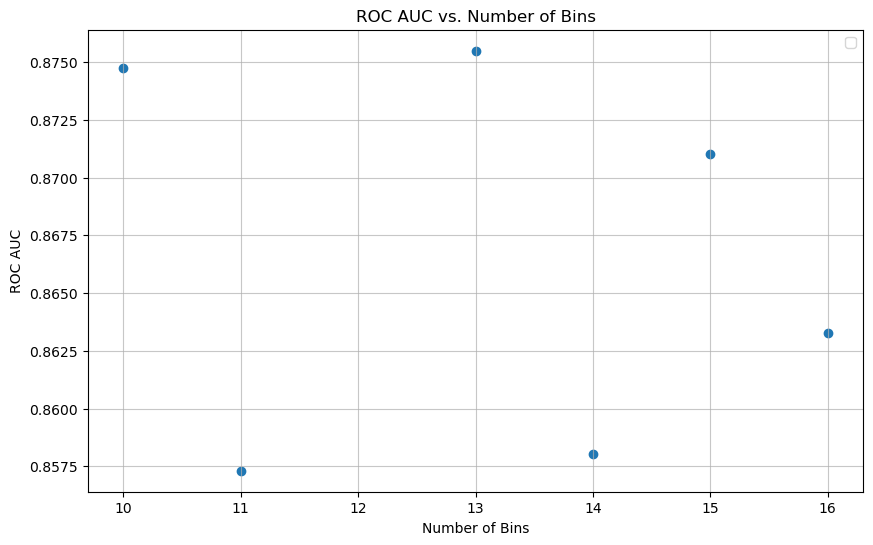

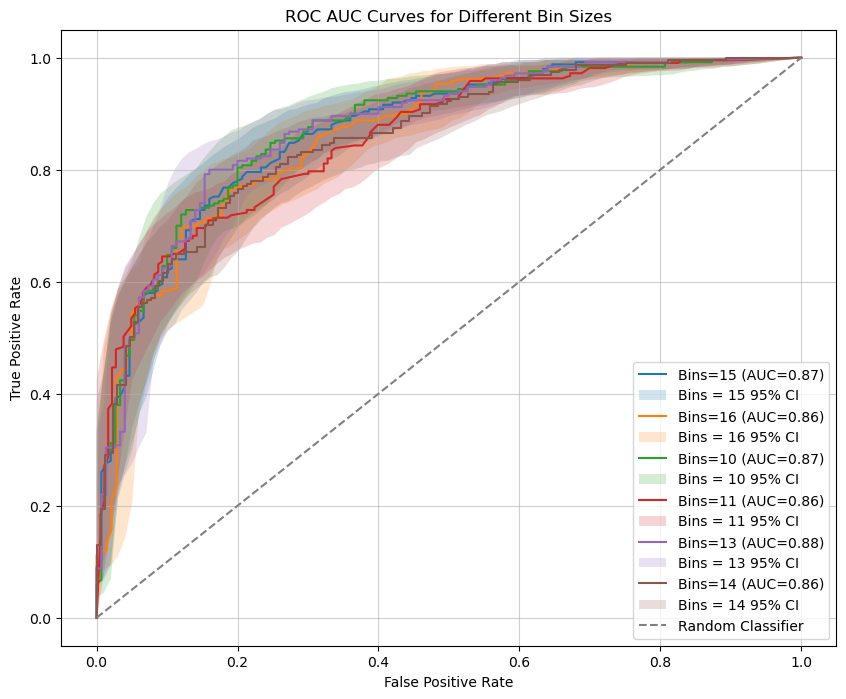

In [7]:
    print(f"Optimal number of bins: {optimal_bins}, with score: {best_score}")
    num_bins = "5-to-25"
    #Plot scores versus bins
    bins,aucs = zip(*roc_auc_values)
    plt.figure(figsize=(10,6))
    plt.scatter(bins, aucs)
    plt.xlabel('Number of Bins')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC vs. Number of Bins')
    plt.grid(alpha=0.7)
    plt.legend()
    plt.savefig(f'ROC-Scores-{num_bins}-bins.png')
    plt.show()

    #plot actual ROC curves
    plt.figure(figsize=(10, 8))
    mean_fpr = np.linspace(0,1,100) #Fixed FPR values, for interpolation
    for num_bins, fpr, tpr, roc_auc,y_test,y_probs in roc_data_plotting:
        n_bootstraps = 1000
        rng = np.random.RandomState(42)
        y_probs = pd.DataFrame(y_probs)
        boot_tprs = []
        for _ in range(n_bootstraps):
            indices = rng.choice(len(y_test),len(y_test),replace=True)

            # Index y_test and y_probs based on the random indices
            y_test_boot = y_test.iloc[indices].values
        
            y_probs_boot = y_probs.iloc[indices].values

            fpr_boot, tpr_boot, _ = roc_curve(y_test_boot, y_probs_boot)
            tpr_interp = np.interp(mean_fpr, fpr_boot, tpr_boot)
            boot_tprs.append(tpr_interp)
        boot_tprs = np.array(boot_tprs)
        tpr_lower = np.percentile(boot_tprs,2.5,axis = 0)
        tpr_upper = np.percentile(boot_tprs,97.5,axis = 0)


        plt.plot(fpr, tpr, label=f'Bins={num_bins} (AUC={roc_auc:.2f})')

        plt.fill_between(mean_fpr,tpr_lower,tpr_upper,alpha = .2, label = f'Bins = {num_bins} 95% CI')
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

    # Customize plot
    plt.title('ROC AUC Curves for Different Bin Sizes')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.6)
    plt.savefig(f'ROC-Curves-{num_bins}-bins.png')

    plt.show()

Final dataset shape: (1998, 15)


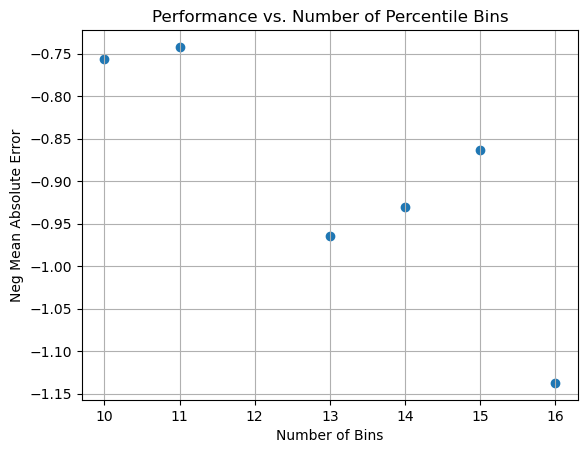

In [8]:
    # Final dataset with optimal bins
    combined_sides_data, bin_threshold = CreateCombinedDataset(full_dataset, num_bins=optimal_bins, plot=True)
    print(f"Final dataset shape: {combined_sides_data.shape}")

    plt.figure()
    # Visualize results
    plt.scatter(mae_results.keys(), mae_results.values(), marker='o')
    plt.title('Performance vs. Number of Percentile Bins')
    plt.xlabel('Number of Bins')
    plt.ylabel('Neg Mean Absolute Error')
    plt.grid()
    plt.savefig(f'Mae-Scores.png')
    plt.show()

BAD Y_PRED DETECTED


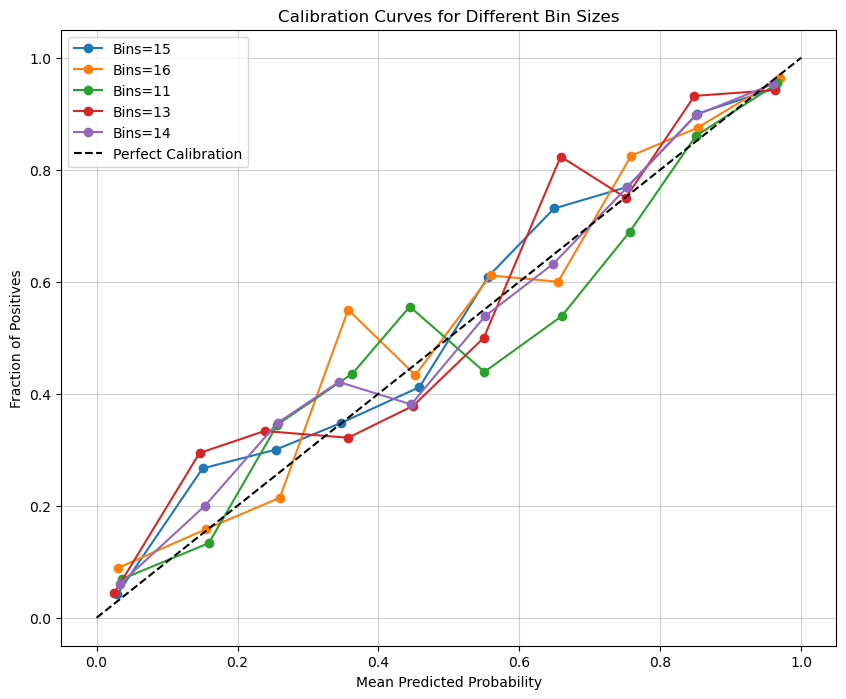

In [9]:
    #Calibration curves

    # Plot calibration curves for all bins
    plt.figure(figsize=(10, 8))

    for bin_size, y_true_binary, y_pred_prob in calibration_data:
        if np.any((y_pred_prob > 1)) or np.any((y_pred_prob < 0)):
            print("BAD Y_PRED DETECTED")
        else:
            prob_true, prob_pred = calibration_curve(y_true_binary, y_pred_prob, n_bins=10, strategy='uniform')
            plt.plot(prob_pred, prob_true, marker='o', label=f'Bins={bin_size}')

    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

    # Customize plot
    plt.title('Calibration Curves for Different Bin Sizes')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid(alpha=0.6)
    plt.savefig("Calibration-Plt.png")
    plt.show()